# Example of discrete and inverse discrete Fourier transform

In [3]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import scipy.signal as signal
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we provide examples of the discrete Fourier transform (DFT) and its inverse, and how `xrft` automatically harnesses the metadata. We compare the results to conventional `numpy.fft` to highlight the strengths of `xrft`.

**Generate synthetic data centered around zero**

In [4]:
k0 = 1/0.52
T = 4.
dx = 0.02
x = np.arange(-2*T,2*T,dx) 
y = np.cos(2*np.pi*k0*x) 
y[np.abs(x)>T/2]=0.
da = xr.DataArray(y, dims=('x',), coords={'x':x})

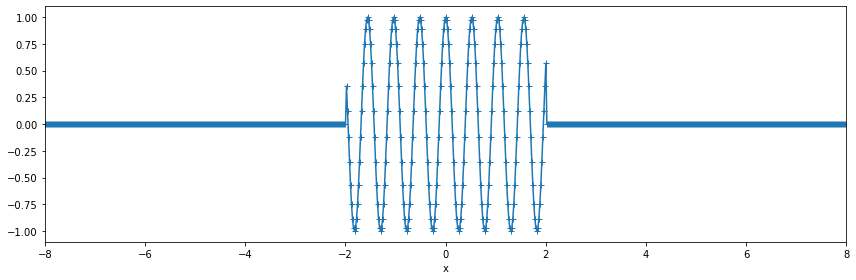

In [5]:
fig, ax = plt.subplots(figsize=(12,4)) 
fig.set_tight_layout(True)
da.plot(ax=ax, marker='+', label='original signal') 
ax.set_xlim([-8,8]);

**Let's take the Fourier transform**

We will compare the Fourier transform with and without taking into consideration about the phase information.

In [6]:
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True) # Fourier Transform w/ consideration of phase
da_fft = xrft.fft(da)                                       # Fourier Transform w/ numpy.fft-like behavior
da_npft = npft.fft(da)

In [7]:
k = da_dft.freq_x # wavenumber axis
TF_s = T/2*(np.sinc(T*(k-k0)) + np.sinc(T*(k+k0))) # Theoretical result of the Fourier transform

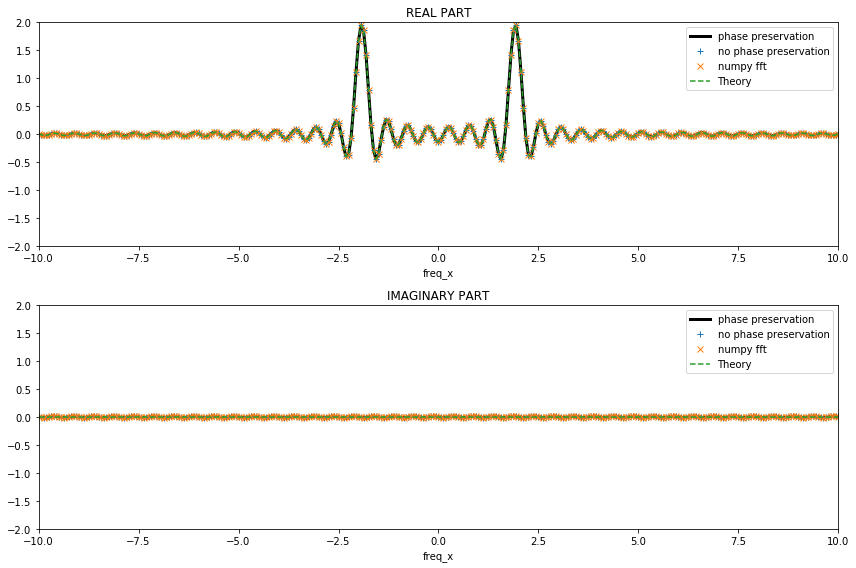

In [13]:
r = (-1)**np.arange(0,len(y))

fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(da_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
(r*(da_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation') 
ax1.plot(k, r*(npft.fftshift(da_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(k, TF_s.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2,2])
ax1.legend()
ax1.set_title('REAL PART')

(da_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
(r*(da_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(k, r*(npft.fftshift(da_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(k, TF_s.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2,2])
ax2.legend()
ax2.set_title('IMAGINARY PART');

`xrft.dft` and `xrft.fft` (and `numpy.fft`) all give the same results as theory (as the coordinates of the original data was centered).

**Perform the inverse transform**

In [9]:
ida_dft = xrft.idft(da_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
ida_fft = xrft.ifft(da_fft)

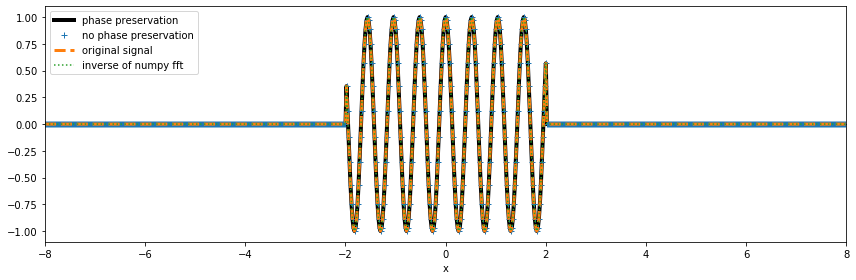

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
ida_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x, ida_fft.real, linestyle='', marker='+', label='no phase preservation') # w/out the phase information, the coordinates are lost
da.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x, npft.ifft(da_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([-8,8])
ax.legend(loc='upper left');

**Now let's shift the coordinates so that they are not centered.**

**This is where the `xrft` magic happens.** With the relevant flags, `xrft`'s dft can preserve information about the data's location in its original space. This information is not preserved in a `numpy` fourier transform. This section demonstrates how to preserve this information using the `true_phase=True`, `true_amplitude=True` flags.

In [21]:
nshift = 70                          # defining a shift
x0 = dx*nshift 
nda = da.shift(x=nshift).dropna('x')

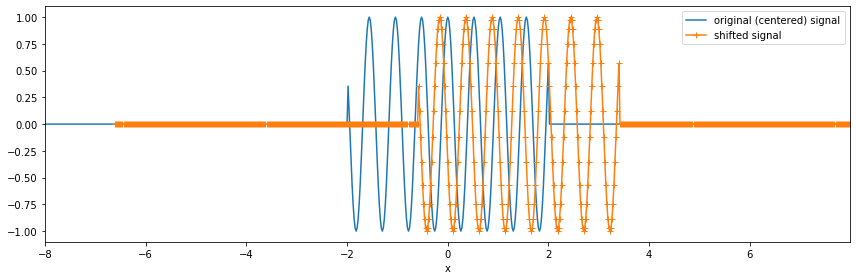

In [22]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
da.plot(ax=ax, label='original (centered) signal') 
nda.plot(ax=ax, marker='+', label='shifted signal') 
ax.set_xlim([-8,nda.x.max()])
ax.legend();

**We consider again the Fourier transform.**

In [23]:
nda_dft = xrft.dft(nda, true_phase=True, true_amplitude=True) # Fourier Transform w/ phase preservation 
nda_fft = xrft.fft(nda)                                       # Fourier Transform w/out phase preservation
nda_npft = npft.fft(nda)

In [24]:
nk = nda_dft.freq_x # wavenumber axis
TF_ns = T/2*(np.sinc(T*(nk-k0)) + np.sinc(T*(nk+k0)))*np.exp(-2j*np.pi*nk*x0) # Theoretical FT (Note the additional phase)

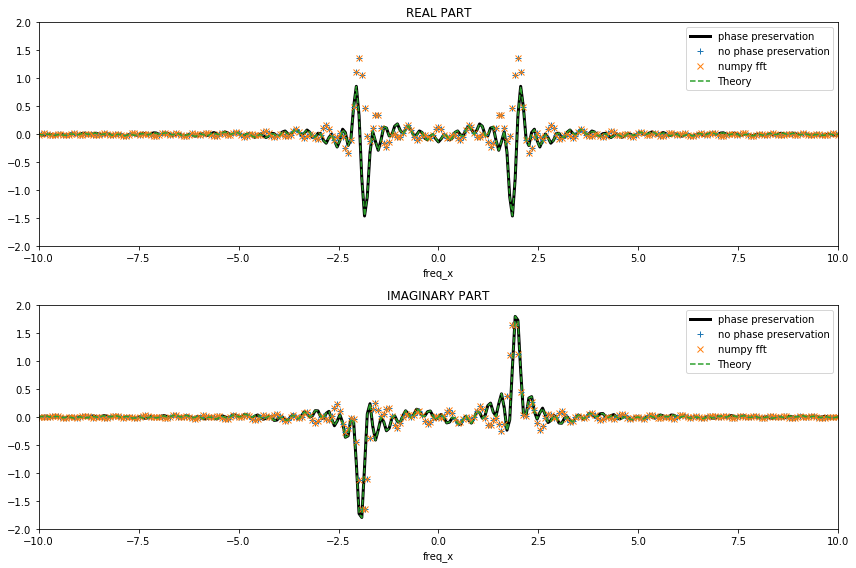

In [25]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(nda_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
(r[nshift:]*(nda_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation')
ax1.plot(nk, r[nshift:]*(npft.fftshift(nda_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(nk, TF_ns.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2.,2])
ax1.legend()
ax1.set_title('REAL PART')

(nda_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
(r[nshift:]*(nda_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(nk, r[nshift:]*(npft.fftshift(nda_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(nk, TF_ns.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2.,2.])
ax2.legend()
ax2.set_title('IMAGINARY PART');

The expected additional phase $e^{-i2\pi kx_0}$ that appears in theory is retrieved with `xrft.dft` but not with `xrft.fft` nor `numpy.fft`. This is because in `numpy.fft`, the input data is expected to be centered around zero. **In the current version of `xrft`, the behavior of `xrft.dft` defaults to `xrft.fft` so set the flags `true_phase=True` and `true_amplitude=True` in order to have the results matching with theory.**

**Now, let's take the inverse transform.**

In [17]:
inda_dft = xrft.idft(nda_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
inda_fft = xrft.ifft(nda_fft)

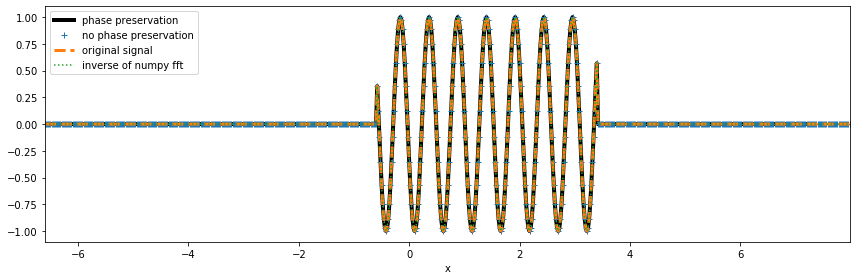

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
inda_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x[nshift:], inda_fft.real, linestyle='', marker='+', label='no phase preservation')
nda.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x[nx:], npft.ifft(nda_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([nda.x.min(),nda.x.max()])
ax.legend(loc='upper left');

Note that we are only able to match the inverse transforms of `xrft.ifft` and `numpy.ifft` to the data `nda` to it being Fourier transformed because we "know" the original data `da` was shifted by `nshift` datapoints as we see in `x[nshift:]`. **Using `xrft.idft` along with `xrft.dft` with the flags `true_phase=True` and `true_amplitude=True` automatically takes care of the information of shifted coordinates.**